In [1]:
# Dependencies

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.5)

In [2]:
# Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split  # not used here, split based on provider
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# for integer encoding using sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve  


from sklearn.metrics import precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

from sklearn.metrics import auc,plot_precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

from sklearn.metrics import roc_curve,auc,RocCurveDisplay

# Set seed for reproducibility
seed1, seed2, seed3=101,67, 42

## Load and Merge Data

In [3]:
# load the data from csv to pandas dataframe
X_test_aggregated_raw = pd.read_csv("output/agg_train_test_split/X_test_new.csv")
X_train_aggregated_raw = pd.read_csv("output/agg_train_test_split/X_train_new.csv")
y_test_aggregated_raw = pd.read_csv("output/agg_train_test_split/y_test_new.csv")
y_train_aggregated_raw = pd.read_csv("output/agg_train_test_split/y_train_new.csv")

In [5]:
X_concat_agg=pd.concat([X_test_aggregated_raw,X_train_aggregated_raw],axis=0)
y_concat_agg=pd.concat([y_test_aggregated_raw,y_train_aggregated_raw],axis=0)
provider_merged_agg=pd.concat([y_concat_agg,X_concat_agg],axis=1)

provider_merged_agg

,PotentialFraud,Provider,DeductibleAmtPaid_mean,DeductibleAmtPaid_max,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,OPAnnualReimbursementAmt_mean,OPAnnualReimbursementAmt_max,OPAnnualReimbursementAmt_sum,OPAnnualDeductibleAmt_mean,...,MeanTeDiagCode_8,MeanTeDiagCode_9,MeanTeDiagCode_10,TotalTeDiagCode,MeanTeProcCode_1,MeanTeProcCode_2,MeanTeProcCode_3,MeanTeProcCode_4,MeanTeProcCode_5,TotalProcCode
0,1,PRV51003,502.166667,1068.0,11.818182,11.871212,2678.181818,31880,353520,737.121212,...,0.419052,0.423177,0.384119,1.245135,0.431365,0.391426,0.380863,0.381155,0.381206,1.203654
1,0,PRV51007,45.333333,1068.0,11.833333,11.833333,1729.722222,6060,124540,469.722222,...,0.378580,0.378804,0.380071,1.129242,0.373426,0.379124,0.380863,0.381155,0.381206,1.133414
2,0,PRV51025,164.183908,1068.0,12.000000,12.000000,2288.965517,23330,199140,621.379310,...,0.379912,0.382826,0.379795,1.151840,0.396727,0.384172,0.380863,0.381155,0.381206,1.161763
3,0,PRV51026,4.473684,100.0,11.684211,12.000000,1811.578947,6700,137680,680.394737,...,0.367247,0.372403,0.379795,1.139064,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
4,0,PRV51041,7.941176,100.0,12.000000,12.000000,2287.647059,28900,77780,613.823529,...,0.367284,0.371186,0.379795,1.093911,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,0,PRV57758,0.000000,0.0,12.000000,12.000000,2570.000000,4340,5140,500.000000,...,0.369850,0.371186,0.379795,1.141532,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
4324,0,PRV57759,4.642857,90.0,12.000000,12.000000,3241.785714,14650,90770,886.785714,...,0.369850,0.371186,0.379795,1.106529,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
4325,0,PRV57760,0.000000,0.0,12.000000,11.727273,1492.727273,4980,32840,805.454545,...,0.369850,0.371186,0.379795,1.120354,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528
4326,0,PRV57761,4.512195,90.0,12.000000,12.000000,2928.414634,25090,240130,707.317073,...,0.369617,0.370118,0.379795,1.118903,0.372540,0.379124,0.380863,0.381155,0.381206,1.132528


In [8]:
import random
for rand_col in X_test_aggregated_raw.columns[1:]:
    rand_max=random.randrange(3, 10, 1)
    X_train_aggregated_raw[rand_col]=[random.randrange(1, rand_max, 1) for i in range(4328)]
    X_test_aggregated_raw[rand_col]=[random.randrange(1, rand_max, 1) for i in range(1082)]

## Basic Transformation

In [9]:
y_train=y_train_aggregated_raw['PotentialFraud']
y_test=y_test_aggregated_raw['PotentialFraud']

X_train=X_train_aggregated_raw.drop('Provider',axis=1).fillna(0)
X_test=X_test_aggregated_raw.drop('Provider',axis=1).fillna(0)

In [10]:
import xgboost as xgb
from sklearn.svm import SVC

xgb_cl = xgb.XGBClassifier()

classification_models={
    'LogisticRegression':LogisticRegression(class_weight = 'balanced',random_state=seed1,max_iter=10000),
#     'RandomForest':RandomForestClassifier(n_estimators = 5, random_state = seed1),
#     'XGBoostregression':xgb.XGBClassifier(n_estimators = 5,random_state = seed1),
#     'SVC': SVC()
}

## Logistic Regression

Training Accuracy Score: 0.611
Testinging Accuracy Score: 0.568
---------------------Train Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.94      0.61      0.74      3925
           1       0.14      0.62      0.23       403

    accuracy                           0.61      4328
   macro avg       0.54      0.62      0.48      4328
weighted avg       0.87      0.61      0.69      4328

---------------------Test Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.90      0.59      0.71       979
           1       0.09      0.37      0.14       103

    accuracy                           0.57      1082
   macro avg       0.49      0.48      0.43      1082
weighted avg       0.82      0.57      0.66      1082

roc_auc_score for the train dataset: 0.67
roc_auc_score for the test dataset: 0.46


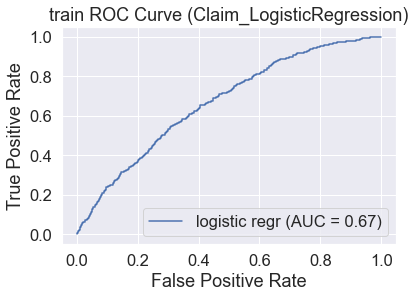

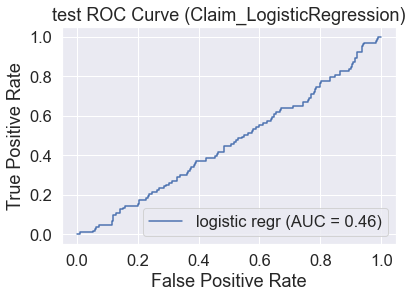

PR-AUC is 0.16


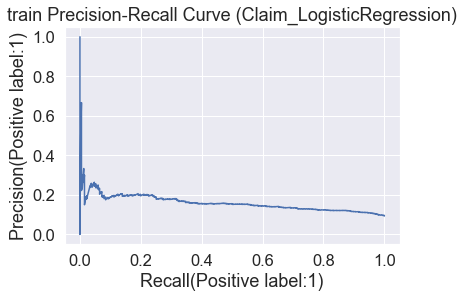

PR-AUC is 0.08


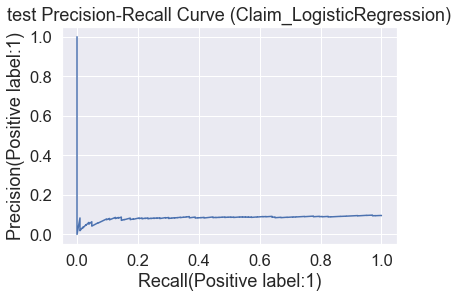

In [11]:
# use StandardScaler and Classification to build a classification pipeline.

classfication_pipeline={}

for key,value in classification_models.items():

    classfication_pipeline[key] = Pipeline([
        #('preprocessor',preprocessor),
        ('rescale', StandardScaler()),
        ('logr', value)
    ])
    
    classfication_pipeline[key]=classfication_pipeline[key].fit(X_train, y_train)
    
    
    # Use the predict function of the model to make predictions for the training set and test set,
    # and assign the outputs to y_train_pred and y_test_pred, respectively.

    y_train_pred = classfication_pipeline[key].predict(X_train)
    y_test_pred = classfication_pipeline[key].predict(X_test)
    
    
    print('Training Accuracy Score: {0:.3f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Testinging Accuracy Score: {0:.3f}'.format(accuracy_score(y_test, y_test_pred)))
    
    
    print('---------------------Train Classification Report--------------------------------\n')
    print(classification_report(y_train, y_train_pred))
    print('---------------------Test Classification Report--------------------------------\n')
    print(classification_report(y_test, y_test_pred))
    
    
    roc_auc_score_train = roc_auc_score(y_train, classfication_pipeline[key].predict_proba(X_train)[:, 1])  
    roc_auc_score_test = roc_auc_score(y_test, classfication_pipeline[key].predict_proba(X_test)[:, 1])
    print('roc_auc_score for the train dataset: {:.2f}'.format(roc_auc_score_train))
    print('roc_auc_score for the test dataset: {:.2f}'.format(roc_auc_score_test))
    
    
    y_train_proba=classfication_pipeline[key].predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, y_train_proba[:,1])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='logistic regr')
    display.plot()

    plt.title('train ROC Curve (Claim_LogisticRegression)')
    plt.show()
    
   
    y_test_proba=classfication_pipeline[key].predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='logistic regr')
    display.plot()

    plt.title('test ROC Curve (Claim_LogisticRegression)')
    plt.show()
    
    
    y_score = y_train_proba[:, 1]

    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_score)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    print('PR-AUC is {:.2f}'.format(auc_precision_recall))

    # plot PR curve
    plt.plot(recall, precision)
    plt.xlabel('Recall(Positive label:1)')
    plt.ylabel('Precision(Positive label:1)')
    plt.title('train Precision-Recall Curve (Claim_LogisticRegression)')
    plt.show()
    
    y_score = y_test_proba[:, 1]

    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    print('PR-AUC is {:.2f}'.format(auc_precision_recall))

    # plot PR curve
    plt.plot(recall, precision)
    plt.xlabel('Recall(Positive label:1)')
    plt.ylabel('Precision(Positive label:1)')
    plt.title('test Precision-Recall Curve (Claim_LogisticRegression)')
    plt.show()

In [ ]:
y_score = y_train_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_train, y_score)

train_pr_df=pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

In [ ]:
len(precision), len(recall), len(thresholds)

In [ ]:
fig = plt.figure(figsize=(8,8),dpi=60)
sns.lineplot(data=train_pr_df, x="thresholds", y="precision",label='precision',marker="s")
sns.lineplot(data=train_pr_df, x="thresholds", y="recall",color='orange',label='recall',marker="s")
plt.legend(loc='lower center')
plt.ylabel('scores')
plt.show()

In [ ]:
y_score = y_test_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

test_pr_df=pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

In [ ]:
fig = plt.figure(figsize=(8,8),dpi=60)
sns.lineplot(data=test_pr_df, x="thresholds", y="precision",label='precision',marker="s")
sns.lineplot(data=test_pr_df, x="thresholds", y="recall",color='orange',label='recall',marker="s")
plt.legend(loc='lower center')
plt.ylabel('scores')
plt.show()